In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "400X"
trainable_blocks = ["block4"]
irun = 4


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_400X-BREAKHIS-Dataset-60-10-30-VGGINet/4'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/400X/4'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 971 files belonging to 2 classes.


Found 161 files belonging to 2 classes.


Found 488 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3664 - accuracy: 0.4688

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/8 [======>.......................] - ETA: 2s - loss: 4.2263 - accuracy: 0.5938

3/8 [==========>...................] - ETA: 4s - loss: 3.7501 - accuracy: 0.6562

4/8 [==============>...............] - ETA: 5s - loss: 3.8720 - accuracy: 0.6699

5/8 [=================>............] - ETA: 3s - loss: 3.9287 - accuracy: 0.6781

6/8 [=====================>........] - ETA: 2s - loss: 3.5056 - accuracy: 0.7070

7/8 [=========================>....] - ETA: 1s - loss: 3.4631 - accuracy: 0.7232

8/8 [==============================] - ETA: 0s - loss: 3.4883 - accuracy: 0.7271

8/8 [==============================] - 21s 3s/step - loss: 3.4883 - accuracy: 0.7271 - val_loss: 19.7638 - val_accuracy: 0.6460


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 2.4847 - accuracy: 0.7891

2/8 [======>.......................] - ETA: 12s - loss: 2.1969 - accuracy: 0.8242

3/8 [==========>...................] - ETA: 9s - loss: 2.5402 - accuracy: 0.8307 

4/8 [==============>...............] - ETA: 7s - loss: 2.4565 - accuracy: 0.8340

5/8 [=================>............] - ETA: 5s - loss: 2.5543 - accuracy: 0.8297

6/8 [=====================>........] - ETA: 3s - loss: 2.2371 - accuracy: 0.8385

7/8 [=========================>....] - ETA: 1s - loss: 2.1644 - accuracy: 0.8393

8/8 [==============================] - ETA: 0s - loss: 2.1814 - accuracy: 0.8383

8/8 [==============================] - 14s 2s/step - loss: 2.1814 - accuracy: 0.8383 - val_loss: 4.2117 - val_accuracy: 0.8385


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 2.0923 - accuracy: 0.8125

2/8 [======>.......................] - ETA: 11s - loss: 1.8747 - accuracy: 0.8125

3/8 [==========>...................] - ETA: 8s - loss: 1.8317 - accuracy: 0.8255 

4/8 [==============>...............] - ETA: 7s - loss: 1.9413 - accuracy: 0.8340

5/8 [=================>............] - ETA: 4s - loss: 2.0253 - accuracy: 0.8422

6/8 [=====================>........] - ETA: 3s - loss: 2.0753 - accuracy: 0.8385

7/8 [=========================>....] - ETA: 1s - loss: 1.9890 - accuracy: 0.8393

8/8 [==============================] - ETA: 0s - loss: 1.9991 - accuracy: 0.8383

8/8 [==============================] - 14s 2s/step - loss: 1.9991 - accuracy: 0.8383 - val_loss: 2.5829 - val_accuracy: 0.8944


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 1.7924 - accuracy: 0.8281

2/8 [======>.......................] - ETA: 11s - loss: 1.6772 - accuracy: 0.8594

3/8 [==========>...................] - ETA: 8s - loss: 1.9206 - accuracy: 0.8359 

4/8 [==============>...............] - ETA: 8s - loss: 1.7578 - accuracy: 0.8457

5/8 [=================>............] - ETA: 5s - loss: 1.7337 - accuracy: 0.8484

6/8 [=====================>........] - ETA: 3s - loss: 1.5777 - accuracy: 0.8594

7/8 [=========================>....] - ETA: 1s - loss: 1.5350 - accuracy: 0.8683

8/8 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.8702

8/8 [==============================] - 15s 2s/step - loss: 1.4463 - accuracy: 0.8702 - val_loss: 2.0890 - val_accuracy: 0.9317


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2667 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 11s - loss: 1.0091 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 10s - loss: 1.0411 - accuracy: 0.8958

4/8 [==============>...............] - ETA: 7s - loss: 1.0566 - accuracy: 0.9023 

5/8 [=================>............] - ETA: 4s - loss: 1.0374 - accuracy: 0.9016

6/8 [=====================>........] - ETA: 3s - loss: 1.0185 - accuracy: 0.8984

7/8 [=========================>....] - ETA: 1s - loss: 0.9814 - accuracy: 0.8996

8/8 [==============================] - ETA: 0s - loss: 1.0202 - accuracy: 0.9001

8/8 [==============================] - 14s 2s/step - loss: 1.0202 - accuracy: 0.9001 - val_loss: 3.0718 - val_accuracy: 0.8447


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 2.0014 - accuracy: 0.8281

2/8 [======>.......................] - ETA: 12s - loss: 1.6458 - accuracy: 0.8477

3/8 [==========>...................] - ETA: 10s - loss: 1.4225 - accuracy: 0.8568

4/8 [==============>...............] - ETA: 7s - loss: 1.3276 - accuracy: 0.8672 

5/8 [=================>............] - ETA: 4s - loss: 1.2962 - accuracy: 0.8719

6/8 [=====================>........] - ETA: 3s - loss: 1.3173 - accuracy: 0.8672

7/8 [=========================>....] - ETA: 1s - loss: 1.2965 - accuracy: 0.8739

8/8 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.8713

8/8 [==============================] - 14s 2s/step - loss: 1.3731 - accuracy: 0.8713 - val_loss: 2.2585 - val_accuracy: 0.9068


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3025 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 11s - loss: 0.9509 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 8s - loss: 1.1851 - accuracy: 0.8802 

4/8 [==============>...............] - ETA: 7s - loss: 1.0980 - accuracy: 0.8828

5/8 [=================>............] - ETA: 5s - loss: 1.0512 - accuracy: 0.8859

6/8 [=====================>........] - ETA: 3s - loss: 1.1232 - accuracy: 0.8789

7/8 [=========================>....] - ETA: 1s - loss: 1.1064 - accuracy: 0.8828

8/8 [==============================] - ETA: 0s - loss: 1.1209 - accuracy: 0.8847

8/8 [==============================] - 14s 2s/step - loss: 1.1209 - accuracy: 0.8847 - val_loss: 1.3225 - val_accuracy: 0.9255


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2892 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 1.5203 - accuracy: 0.8672

3/8 [==========>...................] - ETA: 7s - loss: 1.7554 - accuracy: 0.8542 

4/8 [==============>...............] - ETA: 7s - loss: 1.6092 - accuracy: 0.8555

5/8 [=================>............] - ETA: 4s - loss: 1.4538 - accuracy: 0.8672

6/8 [=====================>........] - ETA: 2s - loss: 1.3583 - accuracy: 0.8789

7/8 [=========================>....] - ETA: 1s - loss: 1.3297 - accuracy: 0.8772

8/8 [==============================] - ETA: 0s - loss: 1.3002 - accuracy: 0.8795

8/8 [==============================] - 13s 2s/step - loss: 1.3002 - accuracy: 0.8795 - val_loss: 1.4841 - val_accuracy: 0.9006


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5086 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 11s - loss: 1.2783 - accuracy: 0.8984

3/8 [==========>...................] - ETA: 8s - loss: 1.2364 - accuracy: 0.9062 

4/8 [==============>...............] - ETA: 7s - loss: 1.3449 - accuracy: 0.8965

5/8 [=================>............] - ETA: 4s - loss: 1.4772 - accuracy: 0.8938

6/8 [=====================>........] - ETA: 3s - loss: 1.5283 - accuracy: 0.8906

7/8 [=========================>....] - ETA: 1s - loss: 1.4252 - accuracy: 0.8917

8/8 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.8898

8/8 [==============================] - 14s 2s/step - loss: 1.3994 - accuracy: 0.8898 - val_loss: 1.8918 - val_accuracy: 0.9068


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7593 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 2.0830 - accuracy: 0.8281

3/8 [==========>...................] - ETA: 8s - loss: 1.9343 - accuracy: 0.8411 

4/8 [==============>...............] - ETA: 7s - loss: 1.5853 - accuracy: 0.8594

5/8 [=================>............] - ETA: 5s - loss: 1.5747 - accuracy: 0.8672

6/8 [=====================>........] - ETA: 3s - loss: 1.5106 - accuracy: 0.8750

7/8 [=========================>....] - ETA: 1s - loss: 1.5547 - accuracy: 0.8795

8/8 [==============================] - ETA: 0s - loss: 1.6564 - accuracy: 0.8733

8/8 [==============================] - 14s 2s/step - loss: 1.6564 - accuracy: 0.8733 - val_loss: 1.7865 - val_accuracy: 0.9379


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6802 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 1.2817 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 10s - loss: 1.3591 - accuracy: 0.8984

4/8 [==============>...............] - ETA: 7s - loss: 1.3180 - accuracy: 0.8965 

5/8 [=================>............] - ETA: 4s - loss: 1.1574 - accuracy: 0.9047

6/8 [=====================>........] - ETA: 3s - loss: 1.2369 - accuracy: 0.9036

7/8 [=========================>....] - ETA: 1s - loss: 1.2979 - accuracy: 0.8996

8/8 [==============================] - ETA: 0s - loss: 1.3381 - accuracy: 0.8950

8/8 [==============================] - 14s 2s/step - loss: 1.3381 - accuracy: 0.8950 - val_loss: 2.4181 - val_accuracy: 0.9193


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9085 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 13s - loss: 1.4062 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 11s - loss: 1.5133 - accuracy: 0.8984

4/8 [==============>...............] - ETA: 7s - loss: 1.6210 - accuracy: 0.8926 

5/8 [=================>............] - ETA: 5s - loss: 1.6237 - accuracy: 0.8953

6/8 [=====================>........] - ETA: 3s - loss: 1.5951 - accuracy: 0.8971

7/8 [=========================>....] - ETA: 1s - loss: 1.5117 - accuracy: 0.8984

8/8 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.8991

8/8 [==============================] - 14s 2s/step - loss: 1.4331 - accuracy: 0.8991 - val_loss: 1.4832 - val_accuracy: 0.8944


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8151 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.2187 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 7s - loss: 1.4902 - accuracy: 0.8906 

4/8 [==============>...............] - ETA: 7s - loss: 1.5003 - accuracy: 0.8867

5/8 [=================>............] - ETA: 4s - loss: 1.3421 - accuracy: 0.8953

6/8 [=====================>........] - ETA: 2s - loss: 1.3118 - accuracy: 0.8958

7/8 [=========================>....] - ETA: 1s - loss: 1.3283 - accuracy: 0.9007

8/8 [==============================] - ETA: 0s - loss: 1.3192 - accuracy: 0.9032

8/8 [==============================] - 13s 2s/step - loss: 1.3192 - accuracy: 0.9032 - val_loss: 1.8241 - val_accuracy: 0.9565


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4121 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 13s - loss: 2.4051 - accuracy: 0.8711

3/8 [==========>...................] - ETA: 9s - loss: 1.7711 - accuracy: 0.8906 

4/8 [==============>...............] - ETA: 7s - loss: 1.4620 - accuracy: 0.9043

5/8 [=================>............] - ETA: 5s - loss: 1.3837 - accuracy: 0.9078

6/8 [=====================>........] - ETA: 3s - loss: 1.3400 - accuracy: 0.9102

7/8 [=========================>....] - ETA: 1s - loss: 1.2312 - accuracy: 0.9152

8/8 [==============================] - ETA: 0s - loss: 1.2579 - accuracy: 0.9104

8/8 [==============================] - 14s 2s/step - loss: 1.2579 - accuracy: 0.9104 - val_loss: 1.4621 - val_accuracy: 0.9006


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6454 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.9603 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 7s - loss: 0.9053 - accuracy: 0.9297 

4/8 [==============>...............] - ETA: 7s - loss: 1.0047 - accuracy: 0.9238

5/8 [=================>............] - ETA: 5s - loss: 0.8860 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 3s - loss: 0.9797 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 1.0728 - accuracy: 0.9185

8/8 [==============================] - ETA: 0s - loss: 1.0458 - accuracy: 0.9197

8/8 [==============================] - 14s 2s/step - loss: 1.0458 - accuracy: 0.9197 - val_loss: 1.5976 - val_accuracy: 0.9255


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2959 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.1343 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 8s - loss: 0.9553 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 1.0546 - accuracy: 0.9258

5/8 [=================>............] - ETA: 4s - loss: 1.0374 - accuracy: 0.9125

6/8 [=====================>........] - ETA: 3s - loss: 0.9598 - accuracy: 0.9141

7/8 [=========================>....] - ETA: 1s - loss: 1.0792 - accuracy: 0.9074

8/8 [==============================] - ETA: 0s - loss: 1.0922 - accuracy: 0.9063

8/8 [==============================] - 14s 2s/step - loss: 1.0922 - accuracy: 0.9063 - val_loss: 1.6236 - val_accuracy: 0.9317


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6486 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 2s - loss: 1.2402 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 3s - loss: 1.0723 - accuracy: 0.9193

4/8 [==============>...............] - ETA: 4s - loss: 1.0519 - accuracy: 0.9160

5/8 [=================>............] - ETA: 3s - loss: 1.1640 - accuracy: 0.9125

6/8 [=====================>........] - ETA: 2s - loss: 1.1206 - accuracy: 0.9154

7/8 [=========================>....] - ETA: 0s - loss: 1.1074 - accuracy: 0.9185

8/8 [==============================] - ETA: 0s - loss: 1.0514 - accuracy: 0.9217

8/8 [==============================] - 11s 1s/step - loss: 1.0514 - accuracy: 0.9217 - val_loss: 1.5621 - val_accuracy: 0.9193


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0349 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 13s - loss: 0.6772 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 12s - loss: 0.6650 - accuracy: 0.9245

4/8 [==============>...............] - ETA: 8s - loss: 0.8419 - accuracy: 0.9062 

5/8 [=================>............] - ETA: 5s - loss: 0.8524 - accuracy: 0.9094

6/8 [=====================>........] - ETA: 3s - loss: 0.9536 - accuracy: 0.9049

7/8 [=========================>....] - ETA: 1s - loss: 0.9229 - accuracy: 0.9051

8/8 [==============================] - ETA: 0s - loss: 0.9103 - accuracy: 0.9073

8/8 [==============================] - 15s 2s/step - loss: 0.9103 - accuracy: 0.9073 - val_loss: 2.1303 - val_accuracy: 0.9068


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5898 - accuracy: 0.8594

2/8 [======>.......................] - ETA: 2s - loss: 1.2763 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 3s - loss: 1.2187 - accuracy: 0.9062

4/8 [==============>...............] - ETA: 4s - loss: 1.0376 - accuracy: 0.9180

5/8 [=================>............] - ETA: 3s - loss: 1.1102 - accuracy: 0.9141

6/8 [=====================>........] - ETA: 2s - loss: 1.1291 - accuracy: 0.9089

7/8 [=========================>....] - ETA: 1s - loss: 1.1869 - accuracy: 0.9074

8/8 [==============================] - ETA: 0s - loss: 1.1727 - accuracy: 0.9073

8/8 [==============================] - 11s 1s/step - loss: 1.1727 - accuracy: 0.9073 - val_loss: 1.9712 - val_accuracy: 0.8758


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7274 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 1.3659 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 8s - loss: 1.5142 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 7s - loss: 1.3811 - accuracy: 0.8984

5/8 [=================>............] - ETA: 5s - loss: 1.2572 - accuracy: 0.9047

6/8 [=====================>........] - ETA: 3s - loss: 1.1075 - accuracy: 0.9128

7/8 [=========================>....] - ETA: 1s - loss: 1.2856 - accuracy: 0.9062

8/8 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.9094

8/8 [==============================] - 14s 2s/step - loss: 1.2603 - accuracy: 0.9094 - val_loss: 1.7473 - val_accuracy: 0.9193


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 1.7571 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 1.4240 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 11s - loss: 1.2665 - accuracy: 0.9167

4/8 [==============>...............] - ETA: 8s - loss: 1.0083 - accuracy: 0.9277 

5/8 [=================>............] - ETA: 5s - loss: 1.0617 - accuracy: 0.9219

6/8 [=====================>........] - ETA: 3s - loss: 0.9835 - accuracy: 0.9271

7/8 [=========================>....] - ETA: 1s - loss: 0.9808 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.9704 - accuracy: 0.9217

8/8 [==============================] - 14s 2s/step - loss: 0.9704 - accuracy: 0.9217 - val_loss: 1.9695 - val_accuracy: 0.9130


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4947 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 13s - loss: 1.5405 - accuracy: 0.8672

3/8 [==========>...................] - ETA: 9s - loss: 1.2201 - accuracy: 0.8958 

4/8 [==============>...............] - ETA: 7s - loss: 1.1871 - accuracy: 0.9043

5/8 [=================>............] - ETA: 5s - loss: 1.1284 - accuracy: 0.9094

6/8 [=====================>........] - ETA: 3s - loss: 1.2831 - accuracy: 0.9036

7/8 [=========================>....] - ETA: 1s - loss: 1.2255 - accuracy: 0.9118

8/8 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.9125

8/8 [==============================] - 14s 2s/step - loss: 1.2296 - accuracy: 0.9125 - val_loss: 2.5353 - val_accuracy: 0.9006


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 1.7311 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.1385 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 0.8082 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 7s - loss: 0.8550 - accuracy: 0.9375

5/8 [=================>............] - ETA: 5s - loss: 0.7731 - accuracy: 0.9375

6/8 [=====================>........] - ETA: 3s - loss: 0.8672 - accuracy: 0.9310

7/8 [=========================>....] - ETA: 1s - loss: 0.7997 - accuracy: 0.9342

8/8 [==============================] - ETA: 0s - loss: 0.7823 - accuracy: 0.9341

8/8 [==============================] - 14s 2s/step - loss: 0.7823 - accuracy: 0.9341 - val_loss: 2.0014 - val_accuracy: 0.9193


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0633 - accuracy: 0.8984

2/8 [======>.......................] - ETA: 8s - loss: 0.6880 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 6s - loss: 0.6858 - accuracy: 0.9349

4/8 [==============>...............] - ETA: 6s - loss: 0.5620 - accuracy: 0.9375

5/8 [=================>............] - ETA: 4s - loss: 0.5416 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 2s - loss: 0.5658 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.5791 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.9372

8/8 [==============================] - 13s 2s/step - loss: 0.5809 - accuracy: 0.9372 - val_loss: 1.7574 - val_accuracy: 0.9130


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7366 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 13s - loss: 0.8753 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 9s - loss: 0.8705 - accuracy: 0.9141 

4/8 [==============>...............] - ETA: 8s - loss: 0.9065 - accuracy: 0.9141

5/8 [=================>............] - ETA: 5s - loss: 0.8431 - accuracy: 0.9203

6/8 [=====================>........] - ETA: 3s - loss: 0.9478 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 0.8483 - accuracy: 0.9263

8/8 [==============================] - ETA: 0s - loss: 0.8850 - accuracy: 0.9248

8/8 [==============================] - 15s 2s/step - loss: 0.8850 - accuracy: 0.9248 - val_loss: 1.5413 - val_accuracy: 0.9193


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2660 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 10s - loss: 0.5426 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 7s - loss: 0.6152 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 6s - loss: 0.5597 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.5444 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 2s - loss: 0.6587 - accuracy: 0.9427

7/8 [=========================>....] - ETA: 1s - loss: 0.6678 - accuracy: 0.9408

8/8 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.9392

8/8 [==============================] - 13s 2s/step - loss: 0.7361 - accuracy: 0.9392 - val_loss: 2.3415 - val_accuracy: 0.8944


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9990 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 13s - loss: 1.2702 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 1.0746 - accuracy: 0.9167 

4/8 [==============>...............] - ETA: 7s - loss: 0.9917 - accuracy: 0.9277

5/8 [=================>............] - ETA: 5s - loss: 0.8917 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 3s - loss: 0.8461 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.7752 - accuracy: 0.9353

8/8 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.9351

8/8 [==============================] - 14s 2s/step - loss: 0.7931 - accuracy: 0.9351 - val_loss: 1.8814 - val_accuracy: 0.9193


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 1.5187 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 1.5055 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 1.4144 - accuracy: 0.9115 

4/8 [==============>...............] - ETA: 7s - loss: 1.1359 - accuracy: 0.9219

5/8 [=================>............] - ETA: 4s - loss: 1.0673 - accuracy: 0.9281

6/8 [=====================>........] - ETA: 3s - loss: 1.0184 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.9579 - accuracy: 0.9330

8/8 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.9351

8/8 [==============================] - 14s 2s/step - loss: 0.8967 - accuracy: 0.9351 - val_loss: 2.0872 - val_accuracy: 0.8882


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3712 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.5329 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.6955 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.5911 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.6039 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 2s - loss: 0.6443 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.7162 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.9434

8/8 [==============================] - 14s 2s/step - loss: 0.7024 - accuracy: 0.9434 - val_loss: 1.5903 - val_accuracy: 0.9317


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6382 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 0.6959 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 8s - loss: 0.6468 - accuracy: 0.9141 

4/8 [==============>...............] - ETA: 7s - loss: 0.6923 - accuracy: 0.9160

5/8 [=================>............] - ETA: 4s - loss: 0.6181 - accuracy: 0.9234

6/8 [=====================>........] - ETA: 2s - loss: 0.7064 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 0.6905 - accuracy: 0.9263

8/8 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.9238

8/8 [==============================] - 13s 2s/step - loss: 0.7427 - accuracy: 0.9238 - val_loss: 2.1016 - val_accuracy: 0.9006


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7412 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.6602 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.7965 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 7s - loss: 0.7214 - accuracy: 0.9414

5/8 [=================>............] - ETA: 5s - loss: 0.7102 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 3s - loss: 0.8533 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 0.7899 - accuracy: 0.9297

8/8 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.9289

8/8 [==============================] - 14s 2s/step - loss: 0.7715 - accuracy: 0.9289 - val_loss: 2.0029 - val_accuracy: 0.9006


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6333 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 0.7904 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 10s - loss: 0.8852 - accuracy: 0.9453

4/8 [==============>...............] - ETA: 7s - loss: 0.7667 - accuracy: 0.9473 

5/8 [=================>............] - ETA: 4s - loss: 0.7122 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.7368 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.6980 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.9464

8/8 [==============================] - 14s 2s/step - loss: 0.6910 - accuracy: 0.9464 - val_loss: 1.6571 - val_accuracy: 0.9068


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2487 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.2393 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.3416 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.5088 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.4684 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 2s - loss: 0.4864 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.5144 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.9506

8/8 [==============================] - 13s 2s/step - loss: 0.5329 - accuracy: 0.9506 - val_loss: 1.6481 - val_accuracy: 0.9193


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1820 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0892 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 0.8363 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 7s - loss: 0.7039 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.6371 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.5917 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.6153 - accuracy: 0.9487

8/8 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.5922 - accuracy: 0.9506 - val_loss: 2.1004 - val_accuracy: 0.8944


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5256 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5377 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.6581 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.7386 - accuracy: 0.9414

5/8 [=================>............] - ETA: 4s - loss: 0.7256 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 2s - loss: 0.7090 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.7264 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.9454

8/8 [==============================] - 13s 2s/step - loss: 0.7107 - accuracy: 0.9454 - val_loss: 1.8920 - val_accuracy: 0.9130


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5118 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.9318 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 8s - loss: 0.9205 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 7s - loss: 0.9488 - accuracy: 0.9414

5/8 [=================>............] - ETA: 5s - loss: 0.9138 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.7745 - accuracy: 0.9531

7/8 [=========================>....] - ETA: 1s - loss: 0.8070 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.9516

8/8 [==============================] - 14s 2s/step - loss: 0.7921 - accuracy: 0.9516 - val_loss: 1.8311 - val_accuracy: 0.9317


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1639 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 2s - loss: 0.8607 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 3s - loss: 0.7956 - accuracy: 0.9323

4/8 [==============>...............] - ETA: 4s - loss: 0.8637 - accuracy: 0.9316

5/8 [=================>............] - ETA: 3s - loss: 0.8590 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 2s - loss: 0.7675 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.7289 - accuracy: 0.9408

8/8 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.9434

8/8 [==============================] - 11s 1s/step - loss: 0.7093 - accuracy: 0.9434 - val_loss: 1.2516 - val_accuracy: 0.9379


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4138 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.2171 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.4230 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.5425 - accuracy: 0.9590

5/8 [=================>............] - ETA: 4s - loss: 0.4957 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 2s - loss: 0.6746 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.9537

8/8 [==============================] - 13s 2s/step - loss: 0.6979 - accuracy: 0.9537 - val_loss: 1.4101 - val_accuracy: 0.9130


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6019 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.7011 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.5275 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.6149 - accuracy: 0.9453

5/8 [=================>............] - ETA: 5s - loss: 0.7070 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.7935 - accuracy: 0.9336

7/8 [=========================>....] - ETA: 1s - loss: 0.9572 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.9279

8/8 [==============================] - 14s 2s/step - loss: 0.9605 - accuracy: 0.9279 - val_loss: 1.7474 - val_accuracy: 0.9379


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3089 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3709 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.3894 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.5810 - accuracy: 0.9375

5/8 [=================>............] - ETA: 5s - loss: 0.5518 - accuracy: 0.9406

6/8 [=====================>........] - ETA: 3s - loss: 0.5863 - accuracy: 0.9427

7/8 [=========================>....] - ETA: 1s - loss: 0.8714 - accuracy: 0.9364

8/8 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.9392

8/8 [==============================] - 14s 2s/step - loss: 0.8264 - accuracy: 0.9392 - val_loss: 2.3180 - val_accuracy: 0.9130


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7287 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.4516 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.4697 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.5309 - accuracy: 0.9492

5/8 [=================>............] - ETA: 5s - loss: 0.6207 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.5327 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.5408 - accuracy: 0.9542

8/8 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.9557

8/8 [==============================] - 14s 2s/step - loss: 0.5366 - accuracy: 0.9557 - val_loss: 2.3595 - val_accuracy: 0.9130


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0674 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.6561 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 7s - loss: 0.5707 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.6813 - accuracy: 0.9336

5/8 [=================>............] - ETA: 5s - loss: 0.6395 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 3s - loss: 0.6247 - accuracy: 0.9388

7/8 [=========================>....] - ETA: 1s - loss: 0.6204 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.9382

8/8 [==============================] - 14s 2s/step - loss: 0.6072 - accuracy: 0.9382 - val_loss: 1.4583 - val_accuracy: 0.9379


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3925 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.2056 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.9281 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.8040 - accuracy: 0.9531

5/8 [=================>............] - ETA: 5s - loss: 0.8275 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 3s - loss: 0.8819 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.9043 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.9320 - accuracy: 0.9413

8/8 [==============================] - 14s 2s/step - loss: 0.9320 - accuracy: 0.9413 - val_loss: 2.2964 - val_accuracy: 0.9130


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4009 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 2s - loss: 0.7814 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 3s - loss: 0.7047 - accuracy: 0.9401

4/8 [==============>...............] - ETA: 4s - loss: 0.7535 - accuracy: 0.9395

5/8 [=================>............] - ETA: 3s - loss: 0.7271 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.7445 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.7867 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.9444

8/8 [==============================] - 11s 1s/step - loss: 0.8063 - accuracy: 0.9444 - val_loss: 1.6720 - val_accuracy: 0.9317


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0125 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.8869 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.7954 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.7586 - accuracy: 0.9512

5/8 [=================>............] - ETA: 4s - loss: 0.7269 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.6620 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.6635 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.7883 - accuracy: 0.9475

8/8 [==============================] - 13s 2s/step - loss: 0.7883 - accuracy: 0.9475 - val_loss: 1.4429 - val_accuracy: 0.9379


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2126 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3590 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.6116 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 7s - loss: 0.4878 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.5240 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.4877 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6084 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.9495

8/8 [==============================] - 14s 2s/step - loss: 0.6420 - accuracy: 0.9495 - val_loss: 2.0220 - val_accuracy: 0.9255


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7704 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4534 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.4505 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3800 - accuracy: 0.9766

5/8 [=================>............] - ETA: 5s - loss: 0.3852 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.4776 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.4902 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.5595 - accuracy: 0.9578 - val_loss: 1.3532 - val_accuracy: 0.9565


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9765 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.1707 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 1.1951 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 7s - loss: 1.0269 - accuracy: 0.9434

5/8 [=================>............] - ETA: 4s - loss: 0.9549 - accuracy: 0.9422

6/8 [=====================>........] - ETA: 2s - loss: 0.9769 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.9220 - accuracy: 0.9442

8/8 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.9423

8/8 [==============================] - 13s 2s/step - loss: 0.9274 - accuracy: 0.9423 - val_loss: 4.0166 - val_accuracy: 0.8696


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9289 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 0.6472 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 7s - loss: 0.5707 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 7s - loss: 0.7794 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.7107 - accuracy: 0.9297

6/8 [=====================>........] - ETA: 2s - loss: 0.6816 - accuracy: 0.9336

7/8 [=========================>....] - ETA: 1s - loss: 0.6597 - accuracy: 0.9353

8/8 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.9331

8/8 [==============================] - 13s 2s/step - loss: 0.6992 - accuracy: 0.9331 - val_loss: 1.0031 - val_accuracy: 0.9317


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1167 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.1742 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2873 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.3982 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.4134 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.5566 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 1s - loss: 0.5362 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.5886 - accuracy: 0.9701 - val_loss: 1.4441 - val_accuracy: 0.9255


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 13s - loss: 0.3709 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 11s - loss: 0.3871 - accuracy: 0.9583

4/8 [==============>...............] - ETA: 7s - loss: 0.3855 - accuracy: 0.9590 

5/8 [=================>............] - ETA: 5s - loss: 0.4538 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.4365 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.4702 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.9609

8/8 [==============================] - 14s 2s/step - loss: 0.4562 - accuracy: 0.9609 - val_loss: 1.4638 - val_accuracy: 0.9317


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4275 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.4346 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 7s - loss: 0.4949 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 6s - loss: 0.6341 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.5411 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 2s - loss: 0.5929 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.6466 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.9578

8/8 [==============================] - 13s 2s/step - loss: 0.6273 - accuracy: 0.9578 - val_loss: 1.8185 - val_accuracy: 0.9317


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4324 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 13s - loss: 1.2140 - accuracy: 0.9297

3/8 [==========>...................] - ETA: 12s - loss: 1.1184 - accuracy: 0.9323

4/8 [==============>...............] - ETA: 8s - loss: 0.9765 - accuracy: 0.9375 

5/8 [=================>............] - ETA: 5s - loss: 0.8836 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.8172 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.7974 - accuracy: 0.9464

8/8 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.9506

8/8 [==============================] - 15s 2s/step - loss: 0.7363 - accuracy: 0.9506 - val_loss: 1.2794 - val_accuracy: 0.9317


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4518 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.8709 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.7460 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.5930 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.6685 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 3s - loss: 0.6221 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6960 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.9547

8/8 [==============================] - 14s 2s/step - loss: 0.6439 - accuracy: 0.9547 - val_loss: 1.8326 - val_accuracy: 0.9255


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3083 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.2640 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.6593 - accuracy: 0.9401 

4/8 [==============>...............] - ETA: 6s - loss: 0.5768 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.6135 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 2s - loss: 0.5414 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6215 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.9526

8/8 [==============================] - 13s 2s/step - loss: 0.6109 - accuracy: 0.9526 - val_loss: 1.3588 - val_accuracy: 0.9317


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5809 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 2s - loss: 0.8262 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 3s - loss: 0.6443 - accuracy: 0.9688

4/8 [==============>...............] - ETA: 4s - loss: 0.5690 - accuracy: 0.9707

5/8 [=================>............] - ETA: 3s - loss: 0.7731 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 1s - loss: 0.7894 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 0s - loss: 0.8564 - accuracy: 0.9576

8/8 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.9588

8/8 [==============================] - 11s 1s/step - loss: 0.8107 - accuracy: 0.9588 - val_loss: 1.5244 - val_accuracy: 0.9068


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0838 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 12s - loss: 0.4624 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4240 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.4067 - accuracy: 0.9590

5/8 [=================>............] - ETA: 4s - loss: 0.4279 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.4237 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.4675 - accuracy: 0.9587

8/8 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.4529 - accuracy: 0.9588 - val_loss: 2.0515 - val_accuracy: 0.9006


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7670 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.5524 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 9s - loss: 0.4545 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.4402 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.5161 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.4603 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.4751 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.5334 - accuracy: 0.9578 - val_loss: 2.7897 - val_accuracy: 0.8509


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5651 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 10s - loss: 0.8162 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 7s - loss: 0.9574 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 6s - loss: 0.8906 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.8349 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 2s - loss: 0.8287 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.7552 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.9526

8/8 [==============================] - 13s 2s/step - loss: 0.7927 - accuracy: 0.9526 - val_loss: 3.0422 - val_accuracy: 0.8944


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0867 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 2s - loss: 0.3379 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 11s - loss: 0.3357 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 7s - loss: 0.5712 - accuracy: 0.9629 

5/8 [=================>............] - ETA: 5s - loss: 0.6250 - accuracy: 0.9563

6/8 [=====================>........] - ETA: 3s - loss: 0.6200 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.6138 - accuracy: 0.9576

8/8 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.9567

8/8 [==============================] - 14s 2s/step - loss: 0.6403 - accuracy: 0.9567 - val_loss: 1.8266 - val_accuracy: 0.9317


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3645 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.5352 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.4341 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.4359 - accuracy: 0.9590

5/8 [=================>............] - ETA: 4s - loss: 0.4651 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.5110 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.5772 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.9516

8/8 [==============================] - 14s 2s/step - loss: 0.5866 - accuracy: 0.9516 - val_loss: 1.9281 - val_accuracy: 0.9317


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2144 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.3630 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 10s - loss: 0.4495 - accuracy: 0.9609

4/8 [==============>...............] - ETA: 7s - loss: 0.4435 - accuracy: 0.9668 

5/8 [=================>............] - ETA: 4s - loss: 0.4588 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.3882 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3658 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.3663 - accuracy: 0.9681 - val_loss: 2.5949 - val_accuracy: 0.9193


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5718 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4622 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4877 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.4466 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.5359 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.5855 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.6016 - accuracy: 0.9576

8/8 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.5783 - accuracy: 0.9578 - val_loss: 1.9855 - val_accuracy: 0.9068


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1595 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.2895 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.5865 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.5178 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.5403 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.5960 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.7203 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.9578

8/8 [==============================] - 14s 2s/step - loss: 0.6667 - accuracy: 0.9578 - val_loss: 1.9900 - val_accuracy: 0.9379


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2035 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2031 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 10s - loss: 0.2485 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 7s - loss: 0.3654 - accuracy: 0.9766 

5/8 [=================>............] - ETA: 4s - loss: 0.3825 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.3851 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3745 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.3986 - accuracy: 0.9670 - val_loss: 2.7624 - val_accuracy: 0.9255


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3091 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.4000 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 9s - loss: 0.4175 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 8s - loss: 0.4497 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3964 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3508 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3594 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.3420 - accuracy: 0.9722 - val_loss: 2.5840 - val_accuracy: 0.9068


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1611 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.7424 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.6251 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.6586 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.6252 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.5385 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.5437 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.5021 - accuracy: 0.9670 - val_loss: 3.3379 - val_accuracy: 0.9317


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1314 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 1.0626 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.7971 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 7s - loss: 0.5998 - accuracy: 0.9609

5/8 [=================>............] - ETA: 4s - loss: 0.6692 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.5895 - accuracy: 0.9622

7/8 [=========================>....] - ETA: 1s - loss: 0.5713 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.9650

8/8 [==============================] - 14s 2s/step - loss: 0.5437 - accuracy: 0.9650 - val_loss: 1.3228 - val_accuracy: 0.9379


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3627 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 13s - loss: 0.1814 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 9s - loss: 0.1702 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.3854 - accuracy: 0.9727

5/8 [=================>............] - ETA: 4s - loss: 0.3893 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.4611 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.4158 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.3837 - accuracy: 0.9712 - val_loss: 1.5395 - val_accuracy: 0.9255


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2680 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.1588 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.2937 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.5108 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.6278 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.5874 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.5593 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.5714 - accuracy: 0.9629 - val_loss: 2.2043 - val_accuracy: 0.9006


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3864 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2416 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 10s - loss: 0.5388 - accuracy: 0.9635

4/8 [==============>...............] - ETA: 7s - loss: 0.5903 - accuracy: 0.9590 

5/8 [=================>............] - ETA: 4s - loss: 0.5586 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 3s - loss: 0.4882 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.4345 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.4229 - accuracy: 0.9670 - val_loss: 1.8014 - val_accuracy: 0.9193


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1650 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1866 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.2335 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.4186 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.4177 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 2s - loss: 0.4117 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.4219 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.9722

8/8 [==============================] - 13s 2s/step - loss: 0.4277 - accuracy: 0.9722 - val_loss: 2.2148 - val_accuracy: 0.9317


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3371 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.3825 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.2730 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 5s - loss: 0.3097 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.3227 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 2s - loss: 0.3123 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.3145 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.9722

8/8 [==============================] - 13s 2s/step - loss: 0.3820 - accuracy: 0.9722 - val_loss: 2.0484 - val_accuracy: 0.9193


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5240 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 3s - loss: 0.4284 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 3s - loss: 0.4772 - accuracy: 0.9583

4/8 [==============>...............] - ETA: 4s - loss: 0.4655 - accuracy: 0.9629

5/8 [=================>............] - ETA: 3s - loss: 0.4550 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 1s - loss: 0.4397 - accuracy: 0.9674

7/8 [=========================>....] - ETA: 0s - loss: 0.4181 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.9640

8/8 [==============================] - 11s 1s/step - loss: 0.4745 - accuracy: 0.9640 - val_loss: 1.6540 - val_accuracy: 0.9317


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2553 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.3672 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.2827 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.2145 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.1808 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.2528 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3318 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.3270 - accuracy: 0.9722 - val_loss: 1.5954 - val_accuracy: 0.9130


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5834 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 13s - loss: 0.4139 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.5335 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.5248 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.6008 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 2s - loss: 0.5276 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.4775 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.9732

8/8 [==============================] - 13s 2s/step - loss: 0.4542 - accuracy: 0.9732 - val_loss: 1.4550 - val_accuracy: 0.9317


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4577 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 2s - loss: 0.4178 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 3s - loss: 0.2843 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 4s - loss: 0.2253 - accuracy: 0.9766

5/8 [=================>............] - ETA: 3s - loss: 0.2725 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.3176 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 0s - loss: 0.3662 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.9712

8/8 [==============================] - 11s 1s/step - loss: 0.3690 - accuracy: 0.9712 - val_loss: 1.7208 - val_accuracy: 0.9317


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8253 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 13s - loss: 0.6356 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 9s - loss: 0.4971 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.5302 - accuracy: 0.9609

5/8 [=================>............] - ETA: 5s - loss: 0.5028 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.4515 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.3899 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.4436 - accuracy: 0.9670 - val_loss: 3.1110 - val_accuracy: 0.9068


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6215 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.0180 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.7874 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.6066 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.5259 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.4680 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.4751 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.5377 - accuracy: 0.9701 - val_loss: 2.5872 - val_accuracy: 0.9130


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0421 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 9s - loss: 0.7459 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 8s - loss: 0.5620 - accuracy: 0.9570

5/8 [=================>............] - ETA: 5s - loss: 0.5260 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.5704 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.5613 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.9578

8/8 [==============================] - 15s 2s/step - loss: 0.6484 - accuracy: 0.9578 - val_loss: 2.2132 - val_accuracy: 0.8882


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2844 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.2253 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.2833 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.2662 - accuracy: 0.9805

5/8 [=================>............] - ETA: 4s - loss: 0.3403 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.3617 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3325 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.9794

8/8 [==============================] - 13s 2s/step - loss: 0.3068 - accuracy: 0.9794 - val_loss: 2.6601 - val_accuracy: 0.9068


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5509 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4125 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.4107 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.3161 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3903 - accuracy: 0.9688

6/8 [=====================>........] - ETA: 3s - loss: 0.3412 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.3572 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.4579 - accuracy: 0.9691 - val_loss: 2.7053 - val_accuracy: 0.8882


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8689 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 10s - loss: 0.5844 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4142 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3783 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.4254 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 2s - loss: 0.4146 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.4059 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.9701

8/8 [==============================] - 13s 2s/step - loss: 0.3983 - accuracy: 0.9701 - val_loss: 2.9746 - val_accuracy: 0.9130


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1759 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2227 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.2621 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.2232 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 3s - loss: 0.2375 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.2586 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.2814 - accuracy: 0.9743 - val_loss: 2.4360 - val_accuracy: 0.9255


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1228 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.6002 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 9s - loss: 0.4730 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.3992 - accuracy: 0.9688

5/8 [=================>............] - ETA: 5s - loss: 0.3540 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.3113 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3234 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.3173 - accuracy: 0.9732 - val_loss: 2.8877 - val_accuracy: 0.8820


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8579 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 9s - loss: 0.5555 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 8s - loss: 0.5121 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.5137 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.4703 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4043 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.9701

8/8 [==============================] - 15s 2s/step - loss: 0.3731 - accuracy: 0.9701 - val_loss: 3.0912 - val_accuracy: 0.8944


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5514 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.6145 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 9s - loss: 0.4431 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 8s - loss: 0.3855 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.3370 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.3661 - accuracy: 0.9688

7/8 [=========================>....] - ETA: 1s - loss: 0.3152 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.9712

8/8 [==============================] - 15s 2s/step - loss: 0.3125 - accuracy: 0.9712 - val_loss: 2.1530 - val_accuracy: 0.9255


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5216 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.6290 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4498 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.6367 - accuracy: 0.9648

5/8 [=================>............] - ETA: 4s - loss: 0.5256 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.5224 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.4689 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.9732

8/8 [==============================] - 14s 2s/step - loss: 0.5189 - accuracy: 0.9732 - val_loss: 2.0014 - val_accuracy: 0.9503


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4298 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 3s - loss: 0.3868 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 3s - loss: 0.3429 - accuracy: 0.9688

4/8 [==============>...............] - ETA: 4s - loss: 0.3645 - accuracy: 0.9688

5/8 [=================>............] - ETA: 3s - loss: 0.3239 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 2s - loss: 0.2768 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2379 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9794

8/8 [==============================] - 11s 1s/step - loss: 0.2340 - accuracy: 0.9794 - val_loss: 2.2672 - val_accuracy: 0.9379


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4399 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.5293 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.5350 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 8s - loss: 0.7431 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.6912 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.7044 - accuracy: 0.9609

7/8 [=========================>....] - ETA: 1s - loss: 0.6340 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.9588

8/8 [==============================] - 14s 2s/step - loss: 0.6541 - accuracy: 0.9588 - val_loss: 2.5154 - val_accuracy: 0.9317


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0602 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3710 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.4774 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3703 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.3950 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3388 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.3993 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.9722

8/8 [==============================] - 14s 2s/step - loss: 0.4044 - accuracy: 0.9722 - val_loss: 3.6995 - val_accuracy: 0.9006


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3642 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2808 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.3962 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.3710 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.3558 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 3s - loss: 0.3705 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4055 - accuracy: 0.9654

8/8 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.9660

8/8 [==============================] - 14s 2s/step - loss: 0.4145 - accuracy: 0.9660 - val_loss: 3.0060 - val_accuracy: 0.9130


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0762 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1040 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.0905 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 8s - loss: 0.1139 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.0981 - accuracy: 0.9859

6/8 [=====================>........] - ETA: 3s - loss: 0.1389 - accuracy: 0.9831

7/8 [=========================>....] - ETA: 1s - loss: 0.1378 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9835

8/8 [==============================] - 15s 2s/step - loss: 0.1271 - accuracy: 0.9835 - val_loss: 2.1936 - val_accuracy: 0.9193


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2697 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3832 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.2726 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.2483 - accuracy: 0.9746

5/8 [=================>............] - ETA: 4s - loss: 0.2580 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.2196 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.2023 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9794

8/8 [==============================] - 14s 2s/step - loss: 0.1867 - accuracy: 0.9794 - val_loss: 3.9030 - val_accuracy: 0.9068


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1722 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.4142 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.2958 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.2420 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.2149 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 3s - loss: 0.2417 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.2144 - accuracy: 0.9833

8/8 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9825

8/8 [==============================] - 14s 2s/step - loss: 0.2452 - accuracy: 0.9825 - val_loss: 4.2148 - val_accuracy: 0.8944


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2929 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.6465 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.5222 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.4706 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.4356 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.4836 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.4527 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.4626 - accuracy: 0.9701 - val_loss: 4.1589 - val_accuracy: 0.8758


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3944 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.5330 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.4315 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3236 - accuracy: 0.9805

5/8 [=================>............] - ETA: 5s - loss: 0.3211 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.2706 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.2320 - accuracy: 0.9833

8/8 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.9794

8/8 [==============================] - 14s 2s/step - loss: 0.2715 - accuracy: 0.9794 - val_loss: 3.5728 - val_accuracy: 0.8882


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3892 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 13s - loss: 0.5364 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 9s - loss: 0.5734 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.5615 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.5631 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.5723 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.6413 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.6327 - accuracy: 0.9743 - val_loss: 2.3716 - val_accuracy: 0.9441


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0687 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1038 - accuracy: 0.9922

3/8 [==========>...................] - ETA: 8s - loss: 0.5399 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.6282 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.5347 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 3s - loss: 0.4457 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.4235 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.4328 - accuracy: 0.9743 - val_loss: 2.1825 - val_accuracy: 0.9317


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5550 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.5227 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.4531 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3890 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.3949 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.4051 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3892 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.4018 - accuracy: 0.9773 - val_loss: 2.6685 - val_accuracy: 0.9317


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

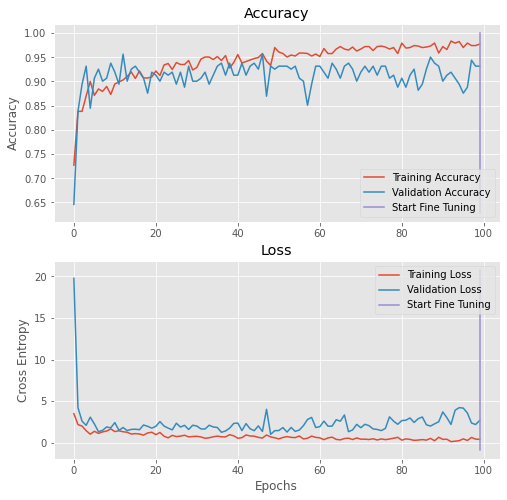

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 8.9546 - accuracy: 0.8047

2/4 [==============>...............] - ETA: 1s - loss: 5.8489 - accuracy: 0.8594

3/4 [=====================>........] - ETA: 1s - loss: 3.9977 - accuracy: 0.9010

4/4 [==============================] - ETA: 0s - loss: 3.3798 - accuracy: 0.9139

4/4 [==============================] - 13s 3s/step - loss: 3.3798 - accuracy: 0.9139


[3.379758358001709, 0.9139344096183777]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

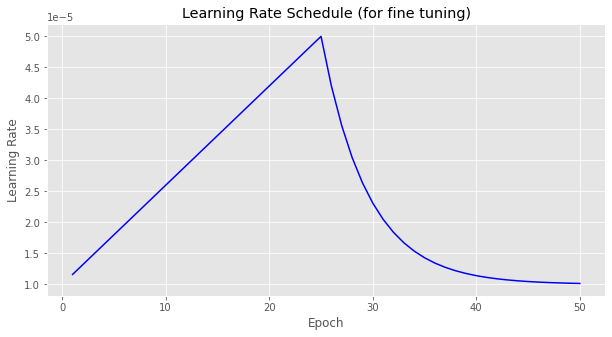

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 971 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3681 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 4s - loss: 0.7832 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 4s - loss: 0.6219 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 8s - loss: 0.7036 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 10s - loss: 0.7454 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 11s - loss: 0.7017 - accuracy: 0.9583

 7/16 [============>.................] - ETA: 9s - loss: 0.6016 - accuracy: 0.9643 

 8/16 [==============>...............] - ETA: 8s - loss: 0.5440 - accuracy: 0.9648

 9/16 [===============>..............] - ETA: 7s - loss: 0.5152 - accuracy: 0.9670

10/16 [=================>............] - ETA: 6s - loss: 0.4639 - accuracy: 0.9703

11/16 [===================>..........] - ETA: 5s - loss: 0.4355 - accuracy: 0.9702

12/16 [=====================>........] - ETA: 4s - loss: 0.4952 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.5080 - accuracy: 0.9688

14/16 [=========================>....] - ETA: 1s - loss: 0.5049 - accuracy: 0.9688

15/16 [===========================>..] - ETA: 0s - loss: 0.5037 - accuracy: 0.9688

16/16 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9681

16/16 [==============================] - 20s 1s/step - loss: 0.5033 - accuracy: 0.9681 - val_loss: 2.4571 - val_accuracy: 0.9193



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5427 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.2957 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.3853 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 12s - loss: 0.2893 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.5143 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 14s - loss: 0.4587 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 11s - loss: 0.4951 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 10s - loss: 0.5210 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 9s - loss: 0.5039 - accuracy: 0.9722 

10/16 [=================>............] - ETA: 7s - loss: 0.4673 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 6s - loss: 0.4417 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 4s - loss: 0.5151 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.4755 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.4995 - accuracy: 0.9721

15/16 [===========================>..] - ETA: 1s - loss: 0.4724 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.4841 - accuracy: 0.9712 - val_loss: 2.3065 - val_accuracy: 0.9255



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4074 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.2230 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 15s - loss: 0.3473 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.2947 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 18s - loss: 0.2855 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 17s - loss: 0.2645 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 13s - loss: 0.2608 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.3762 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 11s - loss: 0.3654 - accuracy: 0.9722

10/16 [=================>............] - ETA: 8s - loss: 0.4020 - accuracy: 0.9719 

11/16 [===================>..........] - ETA: 7s - loss: 0.4153 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.4608 - accuracy: 0.9701

13/16 [=======================>......] - ETA: 3s - loss: 0.4848 - accuracy: 0.9688

14/16 [=========================>....] - ETA: 2s - loss: 0.5129 - accuracy: 0.9688

15/16 [===========================>..] - ETA: 1s - loss: 0.4837 - accuracy: 0.9698

16/16 [==============================] - ETA: 0s - loss: 0.4798 - accuracy: 0.9691

16/16 [==============================] - 21s 1s/step - loss: 0.4798 - accuracy: 0.9691 - val_loss: 2.1817 - val_accuracy: 0.9255



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7353 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 4s - loss: 0.4708 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.3677 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 13s - loss: 0.4410 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 11s - loss: 0.3543 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.4071 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 10s - loss: 0.3533 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 9s - loss: 0.3100 - accuracy: 0.9824 

 9/16 [===============>..............] - ETA: 7s - loss: 0.2898 - accuracy: 0.9826

10/16 [=================>............] - ETA: 6s - loss: 0.2608 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.2955 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 4s - loss: 0.2994 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.3622 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.3707 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.4477 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.9773

16/16 [==============================] - 19s 1s/step - loss: 0.4426 - accuracy: 0.9773 - val_loss: 2.0960 - val_accuracy: 0.9255



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3046 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.9902 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 9s - loss: 0.9594 - accuracy: 0.9531 

 4/16 [======>.......................] - ETA: 10s - loss: 1.0721 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 12s - loss: 0.9068 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 13s - loss: 0.7557 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 13s - loss: 0.6736 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 12s - loss: 0.6225 - accuracy: 0.9688

 9/16 [===============>..............] - ETA: 10s - loss: 0.5815 - accuracy: 0.9688

10/16 [=================>............] - ETA: 8s - loss: 0.6175 - accuracy: 0.9656 

11/16 [===================>..........] - ETA: 6s - loss: 0.5727 - accuracy: 0.9659

12/16 [=====================>........] - ETA: 5s - loss: 0.5250 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.5200 - accuracy: 0.9688

14/16 [=========================>....] - ETA: 2s - loss: 0.4856 - accuracy: 0.9699

15/16 [===========================>..] - ETA: 1s - loss: 0.4709 - accuracy: 0.9698

16/16 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.9701

16/16 [==============================] - 20s 1s/step - loss: 0.4655 - accuracy: 0.9701 - val_loss: 1.9940 - val_accuracy: 0.9193



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4834 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 13s - loss: 0.3045 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 10s - loss: 0.6701 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 10s - loss: 0.5740 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 17s - loss: 0.6213 - accuracy: 0.9594

 6/16 [==========>...................] - ETA: 13s - loss: 0.9592 - accuracy: 0.9531

 7/16 [============>.................] - ETA: 13s - loss: 0.8222 - accuracy: 0.9598

 8/16 [==============>...............] - ETA: 12s - loss: 0.8152 - accuracy: 0.9609

 9/16 [===============>..............] - ETA: 10s - loss: 0.7344 - accuracy: 0.9635

10/16 [=================>............] - ETA: 8s - loss: 0.6609 - accuracy: 0.9672 

11/16 [===================>..........] - ETA: 6s - loss: 0.6067 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.5561 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.5855 - accuracy: 0.9712

14/16 [=========================>....] - ETA: 2s - loss: 0.5437 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.5075 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.9753

16/16 [==============================] - 20s 1s/step - loss: 0.5017 - accuracy: 0.9753 - val_loss: 1.9622 - val_accuracy: 0.9068



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1791 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 8s - loss: 0.1394 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.1747 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 12s - loss: 0.1822 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 12s - loss: 0.1912 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 10s - loss: 0.1642 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 9s - loss: 0.1437 - accuracy: 0.9844 

 9/16 [===============>..............] - ETA: 8s - loss: 0.2114 - accuracy: 0.9809

10/16 [=================>............] - ETA: 6s - loss: 0.1902 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 5s - loss: 0.2538 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.3077 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.3224 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.3506 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3272 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.9794

16/16 [==============================] - 19s 1s/step - loss: 0.3235 - accuracy: 0.9794 - val_loss: 1.9630 - val_accuracy: 0.9130



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/16 [>.............................] - ETA: 0s - loss: 6.5169e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0458 - accuracy: 0.9844    

 3/16 [====>.........................] - ETA: 13s - loss: 0.3180 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 10s - loss: 0.3635 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 17s - loss: 0.4285 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 16s - loss: 0.3631 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 14s - loss: 0.3475 - accuracy: 0.9688

 8/16 [==============>...............] - ETA: 12s - loss: 0.4855 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 10s - loss: 0.4530 - accuracy: 0.9653

10/16 [=================>............] - ETA: 8s - loss: 0.4942 - accuracy: 0.9656 

11/16 [===================>..........] - ETA: 7s - loss: 0.4900 - accuracy: 0.9631

12/16 [=====================>........] - ETA: 5s - loss: 0.4925 - accuracy: 0.9622

13/16 [=======================>......] - ETA: 3s - loss: 0.4606 - accuracy: 0.9639

14/16 [=========================>....] - ETA: 2s - loss: 0.5011 - accuracy: 0.9609

15/16 [===========================>..] - ETA: 1s - loss: 0.4712 - accuracy: 0.9625

16/16 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.9629

16/16 [==============================] - 20s 1s/step - loss: 0.4659 - accuracy: 0.9629 - val_loss: 1.9211 - val_accuracy: 0.9193



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/16 [>.............................] - ETA: 0s - loss: 1.0744 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.7355 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 11s - loss: 0.6846 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 9s - loss: 0.5135 - accuracy: 0.9805 

 5/16 [========>.....................] - ETA: 16s - loss: 0.4109 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.3995 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.5105 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 9s - loss: 0.5409 - accuracy: 0.9746 

 9/16 [===============>..............] - ETA: 8s - loss: 0.5087 - accuracy: 0.9740

10/16 [=================>............] - ETA: 7s - loss: 0.4674 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 6s - loss: 0.4250 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.5048 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.4712 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.4644 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.4830 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.9743

16/16 [==============================] - 19s 1s/step - loss: 0.5093 - accuracy: 0.9743 - val_loss: 1.8799 - val_accuracy: 0.9193



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7987 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.6435 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 14s - loss: 0.8206 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 17s - loss: 0.6404 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 17s - loss: 0.5692 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 16s - loss: 0.4745 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.4067 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.3558 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.3163 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.2855 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.3274 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.3423 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.3278 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.3044 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.3283 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.3246 - accuracy: 0.9815 - val_loss: 1.8898 - val_accuracy: 0.9193



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3338 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 8s - loss: 0.4429 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 16s - loss: 0.3057 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 15s - loss: 0.2498 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 15s - loss: 0.2486 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 14s - loss: 0.4564 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.4036 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 10s - loss: 0.3801 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 9s - loss: 0.3643 - accuracy: 0.9722 

10/16 [=================>............] - ETA: 8s - loss: 0.4012 - accuracy: 0.9719

11/16 [===================>..........] - ETA: 7s - loss: 0.4125 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.3781 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.3632 - accuracy: 0.9724

14/16 [=========================>....] - ETA: 2s - loss: 0.3562 - accuracy: 0.9721

15/16 [===========================>..] - ETA: 1s - loss: 0.3324 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.9743

16/16 [==============================] - 20s 1s/step - loss: 0.3287 - accuracy: 0.9743 - val_loss: 1.8749 - val_accuracy: 0.9193



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/16 [>.............................] - ETA: 0s - loss: 4.3476e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.1441 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 15s - loss: 1.0367 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 12s - loss: 0.8364 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 17s - loss: 0.6704 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 16s - loss: 0.5587 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 15s - loss: 0.5112 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 12s - loss: 0.5092 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.5183 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.4665 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 6s - loss: 0.4403 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.5022 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.4714 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.4377 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.4086 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.4614 - accuracy: 0.9804 - val_loss: 1.8514 - val_accuracy: 0.9130



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 0.0310 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 16s - loss: 0.1948 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.1461 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 12s - loss: 0.2515 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.2646 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.2782 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.2563 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2335 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2189 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.1990 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.1842 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1901 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2266 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2403 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.2375 - accuracy: 0.9784 - val_loss: 1.8358 - val_accuracy: 0.9130



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7536 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.9368 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 17s - loss: 0.9445 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.7599 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 14s - loss: 0.6081 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 17s - loss: 0.5068 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 16s - loss: 0.5052 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.4461 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.4787 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.4308 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.4830 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.5007 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.4839 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.4494 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.4194 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.9804

16/16 [==============================] - 21s 1s/step - loss: 0.4147 - accuracy: 0.9804 - val_loss: 1.8635 - val_accuracy: 0.9130



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3312 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.5876 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 17s - loss: 0.5322 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 14s - loss: 0.5244 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 18s - loss: 0.4438 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 17s - loss: 0.4295 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 16s - loss: 0.4348 - accuracy: 0.9643

 8/16 [==============>...............] - ETA: 13s - loss: 0.4185 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 11s - loss: 0.4225 - accuracy: 0.9688

10/16 [=================>............] - ETA: 9s - loss: 0.3936 - accuracy: 0.9703 

11/16 [===================>..........] - ETA: 7s - loss: 0.3955 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 5s - loss: 0.5137 - accuracy: 0.9688

13/16 [=======================>......] - ETA: 3s - loss: 0.4857 - accuracy: 0.9688

14/16 [=========================>....] - ETA: 2s - loss: 0.5986 - accuracy: 0.9676

15/16 [===========================>..] - ETA: 1s - loss: 0.5668 - accuracy: 0.9688

16/16 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.9691

16/16 [==============================] - 21s 1s/step - loss: 0.5603 - accuracy: 0.9691 - val_loss: 1.8840 - val_accuracy: 0.9193



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/16 [>.............................] - ETA: 0s - loss: 1.4922 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 1.0316 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 18s - loss: 1.1187 - accuracy: 0.9427

 4/16 [======>.......................] - ETA: 15s - loss: 0.9017 - accuracy: 0.9492

 5/16 [========>.....................] - ETA: 12s - loss: 0.7292 - accuracy: 0.9563

 6/16 [==========>...................] - ETA: 13s - loss: 0.6456 - accuracy: 0.9609

 7/16 [============>.................] - ETA: 12s - loss: 0.5534 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 12s - loss: 0.5111 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 10s - loss: 0.4606 - accuracy: 0.9688

10/16 [=================>............] - ETA: 8s - loss: 0.4429 - accuracy: 0.9672 

11/16 [===================>..........] - ETA: 7s - loss: 0.4343 - accuracy: 0.9688

12/16 [=====================>........] - ETA: 5s - loss: 0.3981 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.3675 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.3636 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.3394 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.9743

16/16 [==============================] - 20s 1s/step - loss: 0.3425 - accuracy: 0.9743 - val_loss: 1.8616 - val_accuracy: 0.9193



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4015 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 13s - loss: 0.3793 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 15s - loss: 0.2620 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 19s - loss: 0.1971 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 15s - loss: 0.2216 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.1846 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.1583 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 10s - loss: 0.1447 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 8s - loss: 0.1639 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.2556 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.2324 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.2466 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2771 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2687 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2508 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.2644 - accuracy: 0.9784 - val_loss: 1.8695 - val_accuracy: 0.9193



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7979 - accuracy: 0.9219

 2/16 [==>...........................] - ETA: 7s - loss: 0.4790 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 17s - loss: 0.3193 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 16s - loss: 0.2395 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 13s - loss: 0.4262 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 13s - loss: 0.3966 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.3399 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 10s - loss: 0.3575 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 9s - loss: 0.3803 - accuracy: 0.9757 

10/16 [=================>............] - ETA: 7s - loss: 0.3423 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.3475 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.3609 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3497 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3793 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.3721 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.3679 - accuracy: 0.9773 - val_loss: 1.8787 - val_accuracy: 0.9193



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/16 [>.............................] - ETA: 0s - loss: 1.3004 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 3s - loss: 0.6513 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 12s - loss: 0.4342 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 10s - loss: 0.3261 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 16s - loss: 0.2720 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2270 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 14s - loss: 0.2041 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1852 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.2171 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2785 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.3326 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.3049 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.2936 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.3508 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.3357 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.9825

16/16 [==============================] - 20s 1s/step - loss: 0.3319 - accuracy: 0.9825 - val_loss: 1.9046 - val_accuracy: 0.9193



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7640 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 3s - loss: 0.5757 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 4s - loss: 0.4179 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 9s - loss: 0.3538 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 11s - loss: 0.4444 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 11s - loss: 0.3707 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 9s - loss: 0.3177 - accuracy: 0.9799 

 8/16 [==============>...............] - ETA: 9s - loss: 0.2782 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 7s - loss: 0.2485 - accuracy: 0.9844

10/16 [=================>............] - ETA: 6s - loss: 0.2492 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.2280 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.2245 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 2s - loss: 0.2074 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 1s - loss: 0.1926 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 0s - loss: 0.1804 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9876

16/16 [==============================] - 17s 1s/step - loss: 0.1783 - accuracy: 0.9876 - val_loss: 1.9584 - val_accuracy: 0.9130



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1765 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 9s - loss: 0.0882 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 10s - loss: 0.5533 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.4151 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 11s - loss: 0.5352 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.4460 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.4158 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.4489 - accuracy: 0.9805 

 9/16 [===============>..............] - ETA: 8s - loss: 0.3990 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.3988 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.3649 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 4s - loss: 0.3712 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.4559 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.4234 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.4027 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.9794

16/16 [==============================] - 19s 1s/step - loss: 0.3990 - accuracy: 0.9794 - val_loss: 1.9366 - val_accuracy: 0.9193



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/16 [>.............................] - ETA: 0s - loss: 2.2053e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 2.8647e-05 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 21s - loss: 5.7395e-04 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 17s - loss: 0.0700 - accuracy: 0.9922    

 5/16 [========>.....................] - ETA: 13s - loss: 0.1008 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 14s - loss: 0.1548 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 13s - loss: 0.1329 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1164 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.1155 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1061 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.1325 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1448 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1337 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1284 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1201 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9876

16/16 [==============================] - 21s 1s/step - loss: 0.1188 - accuracy: 0.9876 - val_loss: 1.9390 - val_accuracy: 0.9193



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/16 [>.............................] - ETA: 0s - loss: 3.0206e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 15s - loss: 0.0617 - accuracy: 0.9766   

 3/16 [====>.........................] - ETA: 11s - loss: 0.1167 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 9s - loss: 0.0875 - accuracy: 0.9844 

 5/16 [========>.....................] - ETA: 16s - loss: 0.0724 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.1814 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.1555 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1362 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1272 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1578 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.1537 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.1409 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1664 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.1545 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1801 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.1781 - accuracy: 0.9815 - val_loss: 1.9426 - val_accuracy: 0.9193



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8483e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 4s - loss: 0.4575 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 12s - loss: 0.3450 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 10s - loss: 0.3195 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 13s - loss: 0.2556 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.2130 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.1826 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.1598 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1509 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1358 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.1471 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1659 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1540 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1576 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.1731 - accuracy: 0.9835 - val_loss: 1.9541 - val_accuracy: 0.9193



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5263 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.3988 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 21s - loss: 0.3527 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 16s - loss: 0.2645 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.2116 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.1800 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1543 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 10s - loss: 0.2304 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 8s - loss: 0.2571 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 7s - loss: 0.3324 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 6s - loss: 0.3118 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.2883 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2824 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2623 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2448 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9825

16/16 [==============================] - 20s 1s/step - loss: 0.2420 - accuracy: 0.9825 - val_loss: 1.9280 - val_accuracy: 0.9193



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3562 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 9s - loss: 0.2798 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 15s - loss: 0.4487 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 13s - loss: 0.3643 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 14s - loss: 0.3338 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 14s - loss: 0.2781 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 13s - loss: 0.3707 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 12s - loss: 0.3245 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.3043 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2738 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 7s - loss: 0.2689 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2620 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2438 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2405 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3189 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.9732

16/16 [==============================] - 21s 1s/step - loss: 0.4285 - accuracy: 0.9732 - val_loss: 1.9394 - val_accuracy: 0.9193



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1492 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.2206 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.1478 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 12s - loss: 0.1806 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2712 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 14s - loss: 0.2353 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.2376 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2656 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2505 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2823 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2908 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2796 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2836 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2648 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9815

16/16 [==============================] - 21s 1s/step - loss: 0.2618 - accuracy: 0.9815 - val_loss: 1.9147 - val_accuracy: 0.9193



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0875 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.1761 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 21s - loss: 0.1350 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 16s - loss: 0.1013 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 13s - loss: 0.0810 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 14s - loss: 0.2520 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.2424 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.2907 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 8s - loss: 0.2584 - accuracy: 0.9774 

10/16 [=================>............] - ETA: 7s - loss: 0.2326 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 6s - loss: 0.2560 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.2615 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2672 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2485 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2478 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.2450 - accuracy: 0.9794 - val_loss: 1.9096 - val_accuracy: 0.9193



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7195 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 3s - loss: 0.3756 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 8s - loss: 0.2979 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 13s - loss: 0.5409 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 13s - loss: 0.4327 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 12s - loss: 0.4394 - accuracy: 0.9635

 7/16 [============>.................] - ETA: 10s - loss: 0.3812 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 9s - loss: 0.3384 - accuracy: 0.9688 

 9/16 [===============>..............] - ETA: 7s - loss: 0.3181 - accuracy: 0.9705

10/16 [=================>............] - ETA: 6s - loss: 0.2863 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 5s - loss: 0.3375 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 4s - loss: 0.3357 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.3099 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.2877 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.2696 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.9763

16/16 [==============================] - 19s 1s/step - loss: 0.2665 - accuracy: 0.9763 - val_loss: 1.9095 - val_accuracy: 0.9193



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/16 [>.............................] - ETA: 0s - loss: 2.0862e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 1.0710e-07 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 13s - loss: 0.1545 - accuracy: 0.9896   

 4/16 [======>.......................] - ETA: 12s - loss: 0.1204 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 18s - loss: 0.0964 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 17s - loss: 0.0808 - accuracy: 0.9922

 7/16 [============>.................] - ETA: 16s - loss: 0.0692 - accuracy: 0.9933

 8/16 [==============>...............] - ETA: 12s - loss: 0.0606 - accuracy: 0.9941

 9/16 [===============>..............] - ETA: 11s - loss: 0.0640 - accuracy: 0.9913

10/16 [=================>............] - ETA: 8s - loss: 0.1253 - accuracy: 0.9891 

11/16 [===================>..........] - ETA: 7s - loss: 0.1331 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.1240 - accuracy: 0.9883

13/16 [=======================>......] - ETA: 3s - loss: 0.1496 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1759 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1687 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9846

16/16 [==============================] - 21s 1s/step - loss: 0.1708 - accuracy: 0.9846 - val_loss: 1.9327 - val_accuracy: 0.9193



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7282 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.8177 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 17s - loss: 0.6022 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 19s - loss: 0.5222 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 15s - loss: 0.4489 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 14s - loss: 0.4260 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.3813 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 10s - loss: 0.3432 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 8s - loss: 0.3221 - accuracy: 0.9757 

10/16 [=================>............] - ETA: 7s - loss: 0.3262 - accuracy: 0.9766

11/16 [===================>..........] - ETA: 5s - loss: 0.3079 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2825 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2865 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2955 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.2759 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.2919 - accuracy: 0.9773 - val_loss: 1.9294 - val_accuracy: 0.9193



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150

 1/16 [>.............................] - ETA: 0s - loss: 8.3631e-07 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.8278 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 9s - loss: 0.6726 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.6277 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.5022 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.4484 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.4116 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 11s - loss: 0.4376 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 9s - loss: 0.3898 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 8s - loss: 0.3992 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.3731 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 4s - loss: 0.3754 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.3689 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.3606 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.3427 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.3426 - accuracy: 0.9794 - val_loss: 1.9871 - val_accuracy: 0.9193



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2051 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 14s - loss: 0.2568 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 10s - loss: 0.3605 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 10s - loss: 0.2895 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 17s - loss: 0.2409 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 16s - loss: 0.2996 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 15s - loss: 0.2569 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.2247 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2371 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.2432 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2211 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2352 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2171 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2041 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1905 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9846

16/16 [==============================] - 20s 1s/step - loss: 0.1883 - accuracy: 0.9846 - val_loss: 1.9763 - val_accuracy: 0.9193



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6428 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.3500 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.4172 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 14s - loss: 0.3344 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 13s - loss: 0.2675 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 14s - loss: 0.2275 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.1954 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.1710 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 11s - loss: 0.2285 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.2633 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2722 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.3320 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3205 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3291 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3185 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.3169 - accuracy: 0.9773 - val_loss: 1.9660 - val_accuracy: 0.9193



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/16 [>.............................] - ETA: 0s - loss: 1.1122 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 8s - loss: 0.5561 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 13s - loss: 0.3764 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.3857 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 19s - loss: 0.3194 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 15s - loss: 0.3271 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 14s - loss: 0.2804 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 13s - loss: 0.2825 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 11s - loss: 0.2605 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.2345 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.2747 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2793 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3037 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2820 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3443 - accuracy: 0.9740

16/16 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.9743

16/16 [==============================] - 21s 1s/step - loss: 0.3404 - accuracy: 0.9743 - val_loss: 1.9718 - val_accuracy: 0.9193



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2452 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 24s - loss: 0.1267 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 17s - loss: 0.2975 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.2890 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 15s - loss: 0.2854 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.2378 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.2265 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.2086 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 8s - loss: 0.2427 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 8s - loss: 0.2696 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 7s - loss: 0.2884 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2644 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2454 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2348 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2178 - accuracy: 0.9835 - val_loss: 1.9658 - val_accuracy: 0.9193



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1954 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.5173 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 21s - loss: 0.4056 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 19s - loss: 0.3192 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 15s - loss: 0.2554 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.2532 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.2221 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.2116 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 8s - loss: 0.1957 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.1844 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.2225 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2040 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1998 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.1858 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.1919 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.2088 - accuracy: 0.9835 - val_loss: 1.9722 - val_accuracy: 0.9193



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.8650 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 15s - loss: 0.9556 - accuracy: 0.9531

 4/16 [======>.......................] - ETA: 18s - loss: 0.9030 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 14s - loss: 0.7224 - accuracy: 0.9656

 6/16 [==========>...................] - ETA: 14s - loss: 0.6020 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 13s - loss: 0.5658 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 10s - loss: 0.4951 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 11s - loss: 0.4435 - accuracy: 0.9774

10/16 [=================>............] - ETA: 9s - loss: 0.3994 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 7s - loss: 0.4740 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.4375 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.4326 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.4491 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.4192 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.9773

16/16 [==============================] - 21s 1s/step - loss: 0.4145 - accuracy: 0.9773 - val_loss: 1.9687 - val_accuracy: 0.9130



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5745 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.6665 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 16s - loss: 0.4443 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 16s - loss: 0.4288 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.3617 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 14s - loss: 0.3016 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 11s - loss: 0.3284 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.2882 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 8s - loss: 0.3624 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 7s - loss: 0.3295 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.3407 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.3130 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2943 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2806 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2934 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.2961 - accuracy: 0.9773 - val_loss: 1.9709 - val_accuracy: 0.9130



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/16 [>.............................] - ETA: 0s - loss: 9.5287e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.4431 - accuracy: 0.9688   

 3/16 [====>.........................] - ETA: 17s - loss: 0.4067 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 13s - loss: 0.3108 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 19s - loss: 0.2822 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 18s - loss: 0.2914 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.2510 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 13s - loss: 0.2197 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.2508 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.2347 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 7s - loss: 0.2382 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2588 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2580 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2422 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2911 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.9763

16/16 [==============================] - 22s 1s/step - loss: 0.2878 - accuracy: 0.9763 - val_loss: 1.9789 - val_accuracy: 0.9130



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/16 [>.............................] - ETA: 0s - loss: 7.3376e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 9s - loss: 0.3601 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 12s - loss: 0.5713 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 11s - loss: 0.4989 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 14s - loss: 0.4518 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.3798 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 11s - loss: 0.3643 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.3757 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 9s - loss: 0.4113 - accuracy: 0.9722 

10/16 [=================>............] - ETA: 8s - loss: 0.4634 - accuracy: 0.9703

11/16 [===================>..........] - ETA: 6s - loss: 0.4392 - accuracy: 0.9716

12/16 [=====================>........] - ETA: 5s - loss: 0.4207 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.4090 - accuracy: 0.9712

14/16 [=========================>....] - ETA: 2s - loss: 0.4052 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.3813 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.3850 - accuracy: 0.9712 - val_loss: 1.9675 - val_accuracy: 0.9130



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/16 [>.............................] - ETA: 0s - loss: 4.3342e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 5s - loss: 2.1671e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 10s - loss: 0.0913 - accuracy: 0.9948   

 4/16 [======>.......................] - ETA: 8s - loss: 0.0714 - accuracy: 0.9922 

 5/16 [========>.....................] - ETA: 16s - loss: 0.1903 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 15s - loss: 0.1586 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 14s - loss: 0.1800 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 11s - loss: 0.1664 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.1506 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.1683 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1670 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.1531 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1995 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1978 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2136 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9856

16/16 [==============================] - 19s 1s/step - loss: 0.2112 - accuracy: 0.9856 - val_loss: 1.9450 - val_accuracy: 0.9193



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.0510 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 13s - loss: 0.0935 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.1318 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 15s - loss: 0.1057 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 14s - loss: 0.1628 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 13s - loss: 0.2150 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 11s - loss: 0.1906 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 9s - loss: 0.1866 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 8s - loss: 0.1679 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.1964 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.1975 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.1853 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.1871 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2266 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.2436 - accuracy: 0.9794 - val_loss: 1.9495 - val_accuracy: 0.9193



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/16 [>.............................] - ETA: 0s - loss: 1.3384 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 13s - loss: 0.7624 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 10s - loss: 0.6338 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 10s - loss: 0.5130 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 17s - loss: 0.4510 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 14s - loss: 0.3817 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 13s - loss: 0.3277 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 12s - loss: 0.2869 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.2550 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.2489 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2289 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2098 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1976 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1928 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.1912 - accuracy: 0.9835 - val_loss: 1.9419 - val_accuracy: 0.9255



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5658 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.2829 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 18s - loss: 0.2731 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 14s - loss: 0.2682 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 14s - loss: 0.2146 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.1789 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 12s - loss: 0.1620 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 10s - loss: 0.1683 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 9s - loss: 0.2105 - accuracy: 0.9809 

10/16 [=================>............] - ETA: 7s - loss: 0.1925 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 6s - loss: 0.1750 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.1667 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1602 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1493 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.1393 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9856

16/16 [==============================] - 20s 1s/step - loss: 0.1378 - accuracy: 0.9856 - val_loss: 1.9278 - val_accuracy: 0.9317



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5559 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 5s - loss: 0.2781 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 7s - loss: 0.1854 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 11s - loss: 0.1469 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 12s - loss: 0.1764 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 10s - loss: 0.1784 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 11s - loss: 0.1893 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.1774 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 9s - loss: 0.1751 - accuracy: 0.9792 

10/16 [=================>............] - ETA: 8s - loss: 0.1656 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 6s - loss: 0.2484 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2287 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2117 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.1966 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.2091 - accuracy: 0.9804 - val_loss: 1.9226 - val_accuracy: 0.9317



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9922   

 3/16 [====>.........................] - ETA: 16s - loss: 0.1741 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 20s - loss: 0.1945 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 18s - loss: 0.3544 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2953 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 14s - loss: 0.2531 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.2092 - accuracy: 0.9861

10/16 [=================>............] - ETA: 9s - loss: 0.1882 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.1820 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1891 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1908 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2240 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9856

16/16 [==============================] - 21s 1s/step - loss: 0.2202 - accuracy: 0.9856 - val_loss: 1.9146 - val_accuracy: 0.9317



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3858 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.1929 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 17s - loss: 0.1286 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 16s - loss: 0.0982 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 14s - loss: 0.1594 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 11s - loss: 0.1735 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 10s - loss: 0.1523 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 9s - loss: 0.1389 - accuracy: 0.9896 

10/16 [=================>............] - ETA: 8s - loss: 0.1320 - accuracy: 0.9875

11/16 [===================>..........] - ETA: 6s - loss: 0.1303 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1427 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1525 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.1418 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 1s - loss: 0.1478 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.1462 - accuracy: 0.9866 - val_loss: 1.9201 - val_accuracy: 0.9317



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.0421 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.1013 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.1094 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 19s - loss: 0.0876 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 12s - loss: 0.0812 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 11s - loss: 0.0764 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.0766 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.0916 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.0879 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.0811 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1009 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9846

16/16 [==============================] - 21s 1s/step - loss: 0.0950 - accuracy: 0.9846 - val_loss: 1.9184 - val_accuracy: 0.9317



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2965 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.3039 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 15s - loss: 0.2656 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 14s - loss: 0.1994 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 14s - loss: 0.1633 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 11s - loss: 0.1361 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.1670 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.1461 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.1299 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1169 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.1068 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1687 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1573 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1461 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1918 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9866

16/16 [==============================] - 21s 1s/step - loss: 0.1896 - accuracy: 0.9866 - val_loss: 1.9157 - val_accuracy: 0.9317


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

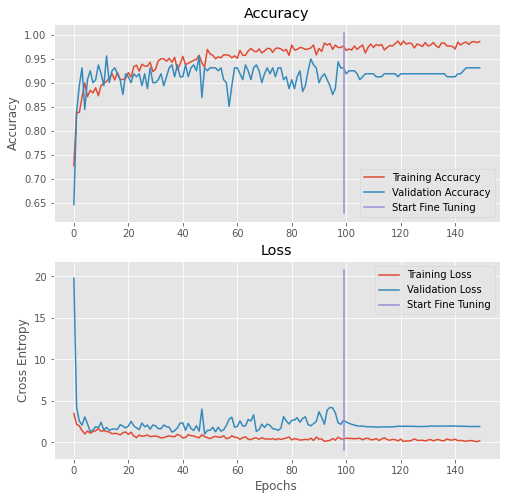

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 4.2772 - accuracy: 0.8750

2/4 [==============>...............] - ETA: 1s - loss: 3.4769 - accuracy: 0.8984

3/4 [=====================>........] - ETA: 1s - loss: 2.4499 - accuracy: 0.9193

4/4 [==============================] - ETA: 0s - loss: 2.1148 - accuracy: 0.9324

4/4 [==============================] - 5s 1s/step - loss: 2.1148 - accuracy: 0.9324


[2.114753484725952, 0.9323770403862]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9323770491803278
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       148
           1       0.94      0.96      0.95       340

    accuracy                           0.93       488
   macro avg       0.93      0.91      0.92       488
weighted avg       0.93      0.93      0.93       488



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

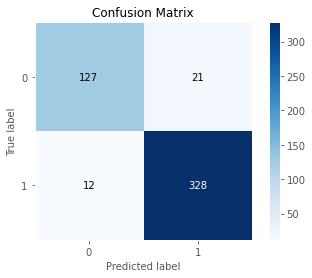

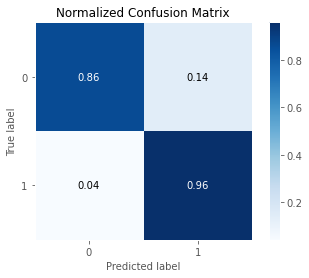

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

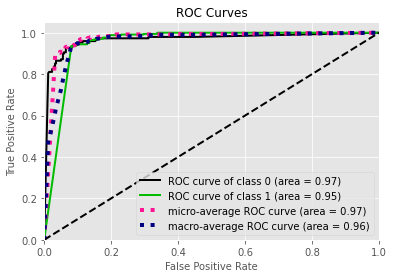

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       148
           1       0.94      0.96      0.95       340

    accuracy                           0.93       488
   macro avg       0.93      0.91      0.92       488
weighted avg       0.93      0.93      0.93       488

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.86      0.96      0.89      0.91      0.82       148
          1       0.94      0.96      0.86      0.95      0.91      0.84       340

avg / total       0.93      0.93      0.89      0.93      0.91      0.83       488

